In [1]:
#!pip install jax
#!pip install -U "jax[cpu]"
#!pip install mat73
#!pip install scikit-learn-extra 
# Comment out the lines above after running them once. 
#!pip install pandas
#!pip install seaborn

# Importing the libraries
import sys
import psutil
import time
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from scipy import signal
from scipy.signal import find_peaks
import json
import mat73
import math
import os
import pandas as pd
import seaborn as sns


In [2]:
def compare_sources(list1, list2, tolerance):
    #tolerance = 5
    duplicate_matches = 0

    list1_matches = set()
    list2_matches = set()
    list1_duplicates = set()
    list2_duplicates = set()

    for  spike_idx in list1:
        for spike2_idx in list2:
            #print(f'Cheking: {spike_idx} & {spike2_idx}')
            #print(f'Difference: {abs(spike_idx-spike2_idx)}')

            if  abs(spike_idx-spike2_idx) < tolerance:  
                if spike_idx not in list1_matches and spike2_idx not in list2_matches:
                    
                    # Add the spike pair to the matched spikes
                    list1_matches.add(spike_idx)
                    list2_matches.add(spike2_idx)

                else:
                    # Add the spike pair to the duplicate list
                    list1_duplicates.add(spike_idx)
                    list2_duplicates.add(spike2_idx)

                    # Incriment the duplicate counter
                    duplicate_matches += 1


            if (spike_idx - spike2_idx) < - tolerance:
                #print('There is no way back!')
                break

    list1_duplicates = list1_duplicates - list1_matches
    list2_duplicates = list2_duplicates - list2_matches

    matched_count = len(list1_matches) + len(list2_matches)
    spikes_with_duplicates = len(set(list1_duplicates)) + len(set(list2_duplicates))
    unmatched_count = len(list1) + len(list2) - matched_count - len(list1_duplicates) - len(list2_duplicates)
    rate_of_agreement = (matched_count / (matched_count + unmatched_count + spikes_with_duplicates)) * 100
    print("Start")
    print(matched_count)
    print(unmatched_count)
    print(spikes_with_duplicates)
    print(len(list1))
    print(len(list2))
    print(rate_of_agreement)
    print("\n")

    return matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement

In [3]:
# Fetch the true sources
file_path = '../data/SIMULATION_56_40.mat'
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)

# Extract the EMG spike data into a numpy array
MUPulses = np.array(data_dict['MUPulses'][0])
print(MUPulses.shape)
print(MUPulses[40].shape)

(56,)
(1, 719)


In [9]:
# Fetch the true sources
file_path_mat = '../data/matlabSpikes300_9_updatedguess.mat'
# Create a dictionary from the matlab data file.
data_dict_mat = scipy.io.loadmat(file_path_mat)


# Extract the EMG spike data into a numpy array
MUPulsesMat = np.array(data_dict_mat['spikeMat'])


spikeList = []
for idx in range(len(MUPulsesMat)):
    sourceList = []
    for index, value in enumerate(MUPulsesMat[idx]):
        if value == 1:
            sourceList.append(index)
    spikeList.append(sourceList)


In [10]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/python300_fixed.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()
MUPulsesB = spikeList

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
dup_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        sourceB = sourceB#['SpikeTrain']
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))

        matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement = compare_sources(sourceA, sourceB, roa_tolerance)

        roa_matrix.iloc[idxA, idxB] = np.round(rate_of_agreement).astype(int)
        dup_matrix.iloc[idxA, idxB] = spikes_with_duplicates

    loopidx = 1

print(roa_matrix)
print(dup_matrix)

(56, 41)
Start
650
850
0
760
740
43.333333333333336


Start
620
858
0
760
718
41.94857916102841


Start
616
907
0
760
763
40.44648719632305


Start
534
939
0
760
713
36.252545824847246


Start
558
921
0
760
719
37.72819472616633


Start
586
909
0
760
735
39.197324414715716


Start
516
985
0
760
741
34.37708194536975


Start
612
865
0
760
717
41.43534190927556


Start
566
881
0
760
687
39.11541119557705


Start
628
855
0
760
723
42.3465947403911


Start
608
857
0
760
705
41.50170648464164


Start
546
941
0
760
727
36.7182246133154


Start
546
921
0
760
707
37.21881390593047


Start
632
830
0
760
702
43.22845417236662


Start
572
941
0
760
753
37.805684071381364


Start
600
896
0
760
736
40.106951871657756


Start
576
889
0
760
705
39.317406143344705


Start
600
850
0
760
690
41.37931034482759


Start
598
857
0
760
695
41.09965635738831


Start
604
900
0
760
744
40.159574468085104


Start
594
859
0
760
693
40.88093599449415


Start
702
805
0
760
747
46.58261446582615


Start
532
983
0
76

In [7]:
# Step 3: Plot the Heatmap
plt.figure(figsize=(15, 8))
plt.imshow(shift_matrix, cmap='hot', interpolation='nearest')

# Step 4: Customize the Plot (Optional)
plt.colorbar()  # Add color bar
plt.xlabel('Found Sources')
plt.ylabel('Ground Truth')
plt.title('Best Shifts')

# Step 5: Show or Save the Plot
plt.show()

NameError: name 'shift_matrix' is not defined

<Figure size 1500x800 with 0 Axes>

In [5]:
def create_binary_list(indices, total_length):
    """
    Create a binary list where indices are marked as 1s.
    """
    binary_list = [0] * (total_length+1)
    for index in indices:
        binary_list[index] = 1
    return binary_list

def calculate_rate_of_agreement(list1, list2):
    """
    Calculate the rate of agreement between two lists of spike indices.
    """
    total_indices = len(list1)+len(list2)
    max_length = max(list1[-1], list2[-1])
    max_agreement = 0
    best_shift = 0
       # Create binary lists for list1 and list2
    binary_list1 = create_binary_list(list1, max_length)
    binary_list2 = create_binary_list(list2, max_length)


    # Iterate through possible shifts
    for shift in range(-10, 11):
        agreement_count = 0

        # Shift binary_list1 by shift amount
        shifted_binary_list1 = [0] * max_length
        if shift < 0:
            shifted_binary_list1[-shift:] = binary_list1[:shift]
        elif shift > 0:
            shifted_binary_list1[:-shift] = binary_list1[shift:]


 
        # Perform element-wise multiplication and sum
        for i in range(max_length):
            agreement_count += shifted_binary_list1[i] * binary_list2[i]

        # Calculate rate of agreement for current shift
        rate_of_agreement = (agreement_count * 2 / total_indices) * 100

        # Update max agreement and best shift if current shift has higher rate of agreement
        if rate_of_agreement > max_agreement:
            max_agreement = rate_of_agreement
            best_shift = shift

    return best_shift, max_agreement

# Example usage
list1 = [1, 3, 5, 7, 9]
list2 = [2, 4, 6, 8, 10]
shift, rate_of_agreement = calculate_rate_of_agreement(list1, list2)
print("Best shift:", shift)
print("Rate of agreement:", rate_of_agreement)

Best shift: -1
Rate of agreement: 80.0


In [6]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/python300_fixed.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()#

#MUPulsesB = spikeList
#MUPulsesA = spikeListB

roa_matrix = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
shift_matrix = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        print(idxA, idxB)
        sourceB = sourceB["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))


        shift, rate_of_agreement = calculate_rate_of_agreement(sourceA, sourceB)

        
        roa_matrix.iloc[idxA, idxB] = rate_of_agreement 
        shift_matrix.iloc[idxA, idxB] = shift 


    loopidx = 1

print(roa_matrix)


(56, 17)
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
1

In [7]:
# Fetch the true sources
file_path_mat = '../data/matlabSpikes300_9_updatedguess.mat'
# Create a dictionary from the matlab data file.
data_dict_mat = scipy.io.loadmat(file_path_mat)


# Extract the EMG spike data into a numpy array
MUPulsesMat = np.array(data_dict_mat['spikeMat'])


spikeListB = []
for idx in range(len(MUPulsesMat)):
    sourceList = []
    for index, value in enumerate(MUPulsesMat[idx]):
        if value == 1:
            sourceList.append(index)
    spikeListB.append(sourceList)


In [8]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/python300_fixed.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()#

MUPulsesB = spikeListB
#MUPulsesA = spikeListB

roa_matrix_b = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
shift_matrix_b = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        print(idxA, idxB)
        sourceB = sourceB#["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))


        shift, rate_of_agreement = calculate_rate_of_agreement(sourceA, sourceB)

        
        roa_matrix_b.iloc[idxA, idxB] = rate_of_agreement 
        shift_matrix_b.iloc[idxA, idxB] = shift 


    loopidx = 1

print(roa_matrix_b)


(56, 17)
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
5 0
5 1
5 2
5 3


In [9]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))

# Opening JSON file
f = open('../data/python300_fixed.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()#

MUPulsesA = spikeListB

roa_matrix_c = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
shift_matrix_c = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix_c.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        print(idxA, idxB)
        sourceB = sourceB["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))


        shift, rate_of_agreement = calculate_rate_of_agreement(sourceA, sourceB)

        
        roa_matrix_c.iloc[idxA, idxB] = rate_of_agreement 
        shift_matrix_c.iloc[idxA, idxB] = shift 


    loopidx = 1

print(roa_matrix_c)


(41, 17)
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
1

   Algorithm A  Algorithm B
0     1.622718     1.621622
1    84.238411    49.801849
2     1.482480    56.319581
3     1.850628     1.978892
4    75.180092     7.989522


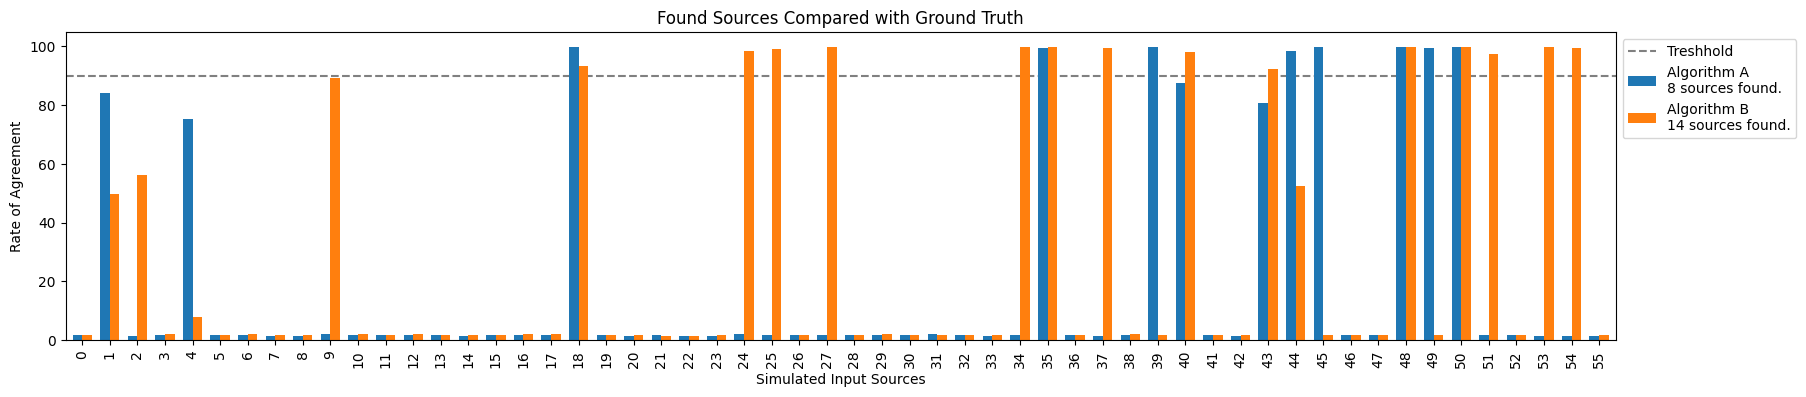

In [10]:
comparision_mx = pd.DataFrame()
comparision_mx['Algorithm A']= roa_matrix.max(axis=1)
comparision_mx['Algorithm B'] = roa_matrix_b.max(axis=1)

print(comparision_mx.head(5))



ax = comparision_mx.plot.bar(figsize=(20,4), width = 0.7)

#plot_df = comparision_mx.reset_index().melt(id_vars='index', var_name='Algorithm', value_name='Rate of Agreement')
#print(plot_df)

#plt.figure(figsize=(15, 3))
plt.axhline(y=90, color='grey', linestyle='--', label= 'Treshhold',  zorder=0)



#sns.barplot(y='index', x='Rate of Agreement', hue='Algorithm', data=plot_df, zorder=2)

#sns.barplot(x=comparision_mx['Algorithm A'].index, y=comparision_mx['Algorithm A'])
#sns.barplot(x=comparision_mx['Algorithm B'].index, y=comparision_mx['Algorithm B'])
plt.legend( loc='upper left', labels=['Treshhold', f'Algorithm A\n{len(comparision_mx[comparision_mx['Algorithm A']>90])} sources found.', f'Algorithm B\n{len(comparision_mx[comparision_mx['Algorithm B']>90])} sources found.'], bbox_to_anchor=(1, 1))

plt.xlabel('Simulated Input Sources')
plt.ylabel('Rate of Agreement')
plt.title('Found Sources Compared with Ground Truth')
plt.show()

In [ ]:
max_index = np.unravel_index(np.argmax(roa_matrix), roa_matrix.shape)

print("Indices of the maximum value:", max_index)

NameError: name 'roa_matrix_b' is not defined

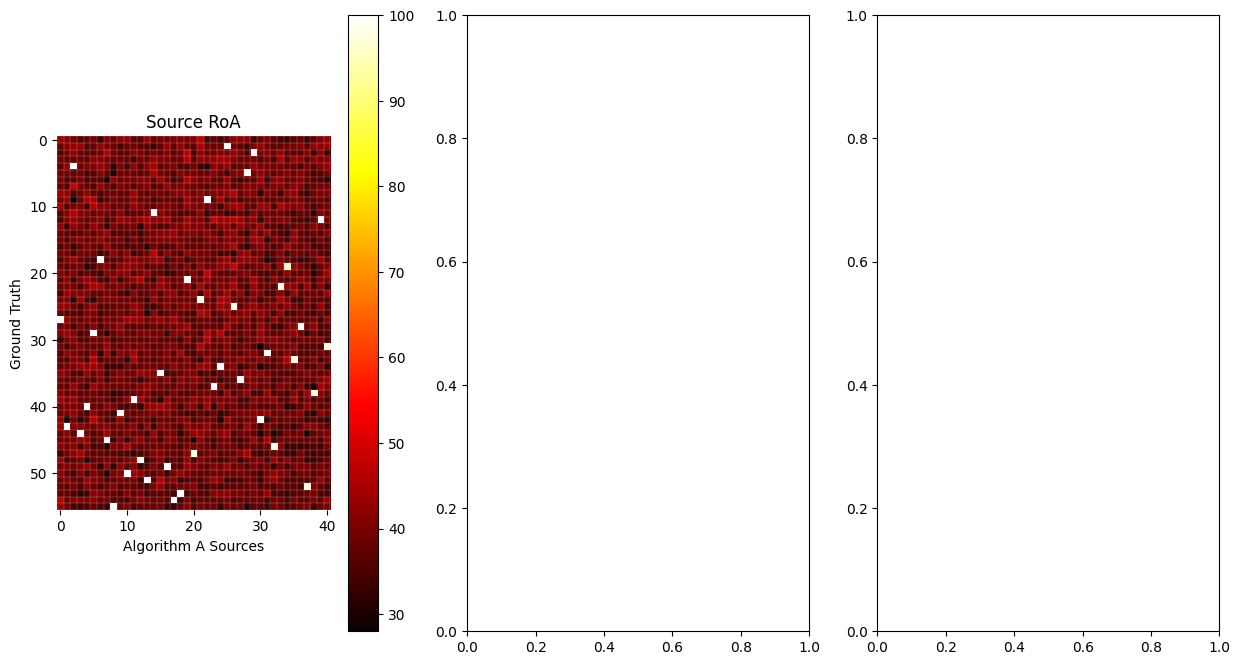

In [11]:
# Step 3: Plot the Heatmap
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))


plot1 = ax1.imshow(roa_matrix, cmap='hot', interpolation='nearest')
# Step 4: Customize the Plot (Optional)
ax1.set_xlabel('Algorithm A Sources')
ax1.set_ylabel('Ground Truth')
ax1.set_title('Source RoA')
plt.colorbar(plot1,ax=ax1)

ax1.spines[:].set_visible(False)
ax1.set_xticks(np.arange(roa_matrix.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(roa_matrix.shape[0]+1)-.5, minor=True)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=0.15) # change the appearance of your padding here
ax1.tick_params(which="minor", bottom=False, left=False)


plot2 = ax2.imshow(roa_matrix_b, cmap='hot', interpolation='nearest')
# Step 4: Customize the Plot (Optional)
ax2.set_xlabel('Algorithm B Sources')
ax2.set_ylabel('Ground Truth')
ax2.set_title('Source RoA')

ax2.spines[:].set_visible(False)
ax2.set_xticks(np.arange(roa_matrix_b.shape[1]+1)-.5, minor=True)
ax2.set_yticks(np.arange(roa_matrix_b.shape[0]+1)-.5, minor=True)
ax2.grid(which="minor", color="w", linestyle='-', linewidth=0.15) # change the appearance of your padding here
ax2.tick_params(which="minor", bottom=False, left=False)
plt.colorbar(plot2,ax=ax2)

plot3 = ax3.imshow(roa_matrix_c, cmap='hot', interpolation='nearest')
# Step 4: Customize the Plot (Optional)
ax3.set_xlabel('Algorithm A Sources')
ax3.set_ylabel('Algorithm B Sources')
ax3.set_title('Source RoA')

ax3.spines[:].set_visible(False)
ax3.set_xticks(np.arange(roa_matrix_c.shape[1]+1)-.5, minor=True)
ax3.set_yticks(np.arange(roa_matrix_c.shape[0]+1)-.5, minor=True)
ax3.grid(which="minor", color="w", linestyle='-', linewidth=0.15) # change the appearance of your padding here
ax3.tick_params(which="minor", bottom=False, left=False)

plt.colorbar(plot3,ax=ax3)

# Step 5: Show or Save the Plot
plt.show()

In [12]:
# Algorithm A 
max_values_a = roa_matrix.max(axis=0)
tp_a = len(max_values_a[max_values_a>90])
fp_a = roa_matrix.shape[1] - tp_a
f1_score_a = tp_a/(0.5*fp_a + tp_a)
prec_a = tp_a/roa_matrix.shape[1]
sens_a = tp_a/56

# Algorithm B 
max_values_b = roa_matrix_b.max(axis=0)
tp_b = len(max_values_b[max_values_b>90])
fp_b = roa_matrix_b.shape[1] - tp_b
f1_score_b = tp_b/(0.5*fp_b + tp_b)
prec_b = tp_b/roa_matrix_b.shape[1]
sens_b = tp_b/56




stats_df = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Precision'], index=['Algorithm A', 'Algorithm B'])




#Algorithm A - f1/sens/prec  
#F1 Score
stats_df.loc['Algorithm A'] = [np.round(f1_score_a*100), np.round(sens_a*100), np.round(prec_a*100)]

#Algorithm B - f1/sens/prec   
stats_df.loc['Algorithm B'] = [np.round(f1_score_b*100), np.round(sens_b*100), np.round(prec_b*100)]

print(stats_df)

            F1 Score Sensitivity Precision
Algorithm A     64.0        14.0      47.0
Algorithm B     51.0        25.0      34.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the first line
sns.lineplot(spikeCountTrue, label='Ground Truth', ax=ax)

# Plot the second line
sns.lineplot(spikeCountCalc, label='Measured', ax=ax)

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Line Plot Example')

# Show the legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
print(shift_matrix[0][18])

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[50][0]
list2 = MUPulsesB[10]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()
print(roa_matrix[7][6])
print(roa_matrix[5][1])

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[6][0]
list2 = MUPulsesB[5]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [ ]:
for list in MUPulsesB:
    plt.figure(figsize=(15, 2))
    time_interval_indices = np.divide(list["SpikeTrain"], 4096)
    plt.vlines(time_interval_indices, 0,1, color='black', linestyle='solid', label='Spikes')
    # Customize the plot as needed
    plt.xlim([0,30])
    plt.xlabel('Time in S')
    plt.title('Spike Train')
    plt.legend()
    plt.show()

In [ ]:
print(np.divide(list2,2))

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[30][0]
list2 = MUPulsesB[12]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [ ]:
sns.heatmap(roa_matrix, cmap='coolwarm')

In [ ]:
sns.heatmap(dup_matrix, cmap='coolwarm')